
# Introduction to Logistic Regression


---

### Learning Objectives
- Distinguish between regression and classification problems.
- Understand how logistic regression is similar to and different from linear regression.
- Fit, generate predictions from, and evaluate a logistic regression model in `sklearn`.
- Understand how to interpret the coefficients of logistic regression.
- Know the benefits of logistic regression as a classifier.

<a id='introduction'></a>

## Introduction

---

Logistic regression is a natural bridge to connect regression and classification.
- Logistic regression is the most common binary classification algorithm.
- Because it is a regression model, logistic regression will predict continuous values.
    - Logistic regression will predict continuous probabilities between 0 and 1.
    - Example: What is the probability that someone shows up to vote?
- However, logistic regression almost always operates as a classification model.
    - Logistic regression will use these continuous predictions to classify something as 0 or 1.
    - Example: Based on the predicted probability, do we predict that someone votes?

In this lecture, we'll only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to predicting outcomes with 3 or more classes.

**Some examples of when logistic regression could be used:**
- Will a user will purchase a product, given characteristics like income, age, and number of family members?
- Does this patient have a specific disease based on their symptoms?
- Will a person default on their loan?
- Is the iris flower in front of me an "*Iris versicolor*?"
- Given one's GPA and the prestige of a college, will a student be admitted to a specific graduate program?

And many more.

In [62]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import train_test_split.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Import logistic regression
import seaborn as sns

## Graduate School Admissions

---

Today, we'll be applying logistic regression to solve the following problem: "Given one's GPA, will a student be admitted to a specific graduate program?"

In [63]:
# Read in the data.
grad = pd.read_csv("data/grad_admissions.csv")

In [64]:
# Check first five rows.
grad.head(5)

,admit,gre,gpa
0,0,380.0,2.915018
1,1,660.0,4.044540
2,1,800.0,4.950714
3,1,640.0,3.921994
4,0,520.0,2.069878


The columns are:
- `admit`: A binary 0/1 variable indicating whether or not a student was admitted, where 1 means admitted and 0 means not admitted.
- `gre`: The student's [GRE (Graduate Record Exam)](https://en.wikipedia.org/wiki/Graduate_Record_Examinations) score.
- `gpa`: The student's GPA.

In [65]:
# How many missing values do we have in each column?
print(grad["gre"].info())
print(grad["gpa"].info())
# 20 missing gvalues in each

<class 'pandas.core.series.Series'>
RangeIndex: 4000 entries, 0 to 3999
Series name: gre
Non-Null Count  Dtype  
--------------  -----  
3980 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 4000 entries, 0 to 3999
Series name: gpa
Non-Null Count  Dtype  
--------------  -----  
3980 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB
None


In [66]:
# Drop every row that has an NA.
grad.drop(grad[grad.isnull().any(axis=1)].index, axis=0, inplace=True)

In [67]:
grad["gre"].info()

<class 'pandas.core.series.Series'>
Index: 3970 entries, 0 to 3999
Series name: gre
Non-Null Count  Dtype  
--------------  -----  
3970 non-null   float64
dtypes: float64(1)
memory usage: 62.0 KB


<details><summary>What assumption are we making when we drop rows that have at least one NA in it?</summary>
    
- We assume that what we drop looks like what we have observed. That is, there's nothing special about the rows we happened to drop.
- We might say that what we dropped is a random sample of our whole data.
- It's not important to know this now, but the formal term is that our data is missing completely at random.
</details>

## Recap of Notation

You're quite familiar with **linear** regression:

$$
\begin{eqnarray*}
\hat{\mathbf{y}} &=& \hat{\beta}_0 + \hat{\beta}_1x_1 + \hat{\beta}_2x_2 + \cdots + \hat{\beta}_px_p \\
&=& \hat{\beta}_0 + \sum_{j=1}^p\hat{\beta}_jX_j
\end{eqnarray*}
$$

Where:
- $\hat{\mathbf{y}}$ is the predicted values of $\mathbf{y}$ based on all of the inputs $x_j$.
- $x_1$, $x_2$, $\ldots$, $x_p$ are the predictors.
- $\hat{\beta}_0$ is the estimated intercept.
- $\hat{\beta}_j$ is the estimated coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$.


<a id='plot-reg'></a>
### What if we predicted `admit` with `gpa` using Linear Regression?

Looking at the plot below, what are problems with using a regression?

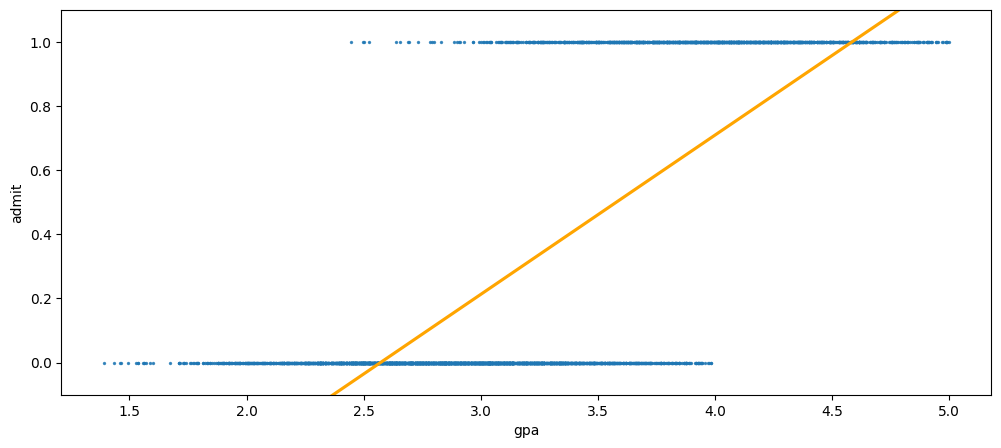

In [68]:
# plot admissions vs. gpa and line of best fit
plt.figure(figsize = (12, 5))
sns.regplot(x=grad['gpa'], y=grad['admit'], data=grad,
            ci = False, scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1);

<a id='pred-binary'></a>

## Predicting a Binary Class

---

In our case we have two classes: `1=admitted` and `0=rejected`.

The logistic regression is still solving for $\hat{y}$. However, in our binary classification case, $\hat{y}$ will be the probability of $y$ being one of the classes.

$$
\hat{y} = P(y = 1)
$$

We'll still try to fit a "line" of best fit to this... except it won't be perfectly linear. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability. (That is, some number between 0 and 1!)

## The Logit Link Function (advanced)

---

We will use something called a **link function** to effectively "bend" our line of best fit so that it is a curve of best fit that matches the range or set of values in which we're interested.

For logistic regression, that specific link function that transforms ("bends") our line is known as the **logit** link.

$$
\text{logit}\left(P(y = 1)\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p
$$

$$
\log\left(\frac{P(y = 1)}{1 - P(y = 1)}\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p
$$

Equivalently, we assume that each independent variable $x_i$ is linearly related to the **log of the odds of success**.

Remember, the purpose of the link function is to bend our line of best fit.
- This is convenient because we can have any values of $X$ inputs that we want, and we'll only ever predict between 0 and 1!
- However, interpreting a one-unit change gets a little harder. (More on this later.)

<img src="./images/logregmeme.png" style="height: 400px">

[*image source*](https://twitter.com/ChelseaParlett/status/1279111984433127425?s=20)

## Fitting and making predictions with the logistic regression model.

We can follow the same steps to build a logistic regression model that we follow to build a linear regression model.

1. Define X & y
2. Instantiate the model.
3. Fit the model.
4. Generate predictions.
5. Evaluate model.

In [85]:
X = grad.loc[:,["gpa"]]
Y = grad["admit"]
print(X.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3970 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gpa     3970 non-null   float64
dtypes: float64(1)
memory usage: 62.0 KB
None
<class 'pandas.core.series.Series'>
Index: 3970 entries, 0 to 3999
Series name: admit
Non-Null Count  Dtype
--------------  -----
3970 non-null   int64
dtypes: int64(1)
memory usage: 62.0 KB
None


In [86]:
# Step 1: Split into training & testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [87]:
print(x_test.info())
print(x_train.info())
print(y_test.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 1767 to 425
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gpa     993 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2977 entries, 3707 to 2026
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gpa     2977 non-null   float64
dtypes: float64(1)
memory usage: 46.5 KB
None
<class 'pandas.core.series.Series'>
Index: 993 entries, 1767 to 425
Series name: admit
Non-Null Count  Dtype
--------------  -----
993 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB
None
<class 'pandas.core.series.Series'>
Index: 2977 entries, 3707 to 2026
Series name: admit
Non-Null Count  Dtype
--------------  -----
2977 non-null   int64
dtypes: int64(1)
memory usage: 46.5 KB
None


In [105]:
# Step 2: Instantiate our model.
reg = LogisticRegression(penalty=None)
# Step 3: Fit our model.
reg.fit(x_train, y_train)


LogisticRegression(penalty=None)

There are two methods in `sklearn` to be aware of when using logistic regression:
- `.predict()`
- `.predict_proba()`

In [106]:
# Step 4 (part 1): Generate predicted values.
reg.predict(x_train)

array([0, 0, 0, ..., 0, 1, 1])

In [107]:
# Step 4 (part 2): Generate predicted probabilities.
reg.predict_proba(x_train)

array([[0.99471409, 0.00528591],
       [0.9982658 , 0.0017342 ],
       [0.56267311, 0.43732689],
       ...,
       [0.98201505, 0.01798495],
       [0.04319472, 0.95680528],
       [0.02411052, 0.97588948]])

<details><summary>How would you interpret the predict_proba() output?</summary>
    
- This shows the probability of being rejected ($P(Y=0)$) and the probability of being admitted ($P(Y=1)$) for each observation in the testing dataset.
- The first array, corresponds to the first testing observation.
    - The `.predict()` value for this observation is 0. This is because $P(Y=0) > P(Y=1)$.
- The second array, corresponds to the second testing observation.
    - The `.predict()` value for this observation is 0. This is because $P(Y=0) > P(Y=1)$.
</details>

In [108]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 1767 to 425
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gpa     993 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB


In [109]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 993 entries, 1767 to 425
Series name: admit
Non-Null Count  Dtype
--------------  -----
993 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


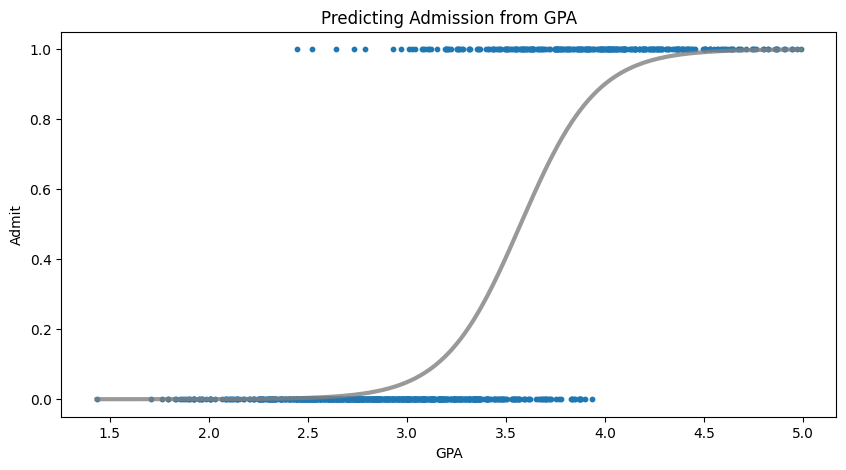

In [110]:
# Visualizing logistic regression probabilities.

plt.figure(figsize = (10, 5))

plt.scatter(x_test["gpa"], y_test, s = 10);

plt.plot(x_test.sort_values('gpa'),
         reg.predict_proba(x_test.sort_values('gpa'))[:,1],
         color = 'grey', alpha = 0.8, lw = 3)

plt.xlabel('GPA')
plt.ylabel('Admit')
plt.title('Predicting Admission from GPA');

In [111]:
# Step 5: Evaluate model.
reg.score(x_test, y_test)

0.8982880161127895

In [112]:
reg.score(x_train, y_train)

0.8965401410816258

By default, the `.score()` method for classification models gives us the accuracy score.

$$
\begin{eqnarray*}
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{number of total predictions}}
\end{eqnarray*}
$$

<details><summary>Remind me: what does .score() tell me for a regression model?</summary>
    
- The $R^2$ score.
- Remember that $R^2$ is the proportion of variance in our $Y$ values that are explained by our model.
</details>

### Using the log-odds —the natural logarithm of the odds.

The combination of converting the "probability of success" to "odds of success," then taking the logarithm of that is called the **logit link function**.

$$
\text{logit}\big(P(y=1)\big) = \log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p
$$

We've bent our line how we want... but how do we interpret our coefficients?

### Odds

Probabilities and odds represent the same thing in different ways. The odds for probability **p** is defined as:

$$
\text{odds}(p) = \frac{p}{1-p}
$$

The odds of a probability is a measure of how many times as likely an event is to happen than it is to not happen.

**Example**: Suppose I'm looking at the probability and odds of a specific horse, "Secretariat," winning a race.

- When **`p = 0.5`**: **`odds = 1`**
    - The horse Secretariat is as likely to win as it is to lose.
- When **`p = 0.75`**: **`odds = 3`**
    - The horse Secretariat is three times as likely to win as it is to lose.
- When **`p = 0.40`**: **`odds = 0.666..`**
   - The horse Secretariat is two-thirds as likely to win as it is to lose.

## Interpreting a one-unit change in $x_i$.

$$\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

Given this model, a one-unit change in $x_i$ implies a $\beta_i$ unit change in the log odds of success.

**This is annoying**.

We often convert log-odds back to "regular odds" when interpreting our coefficient... our mind understands odds better than the log of odds.

**(BONUS)** So, let's get rid of the log on the left-hand side. Mathematically, we do this by "exponentiating" each side.
$$
\begin{eqnarray*}
\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) &=& \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p \\
\Rightarrow e^{\Bigg(\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg)\Bigg)} &=& e^{\Bigg(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p\Bigg)} \\
\Rightarrow \frac{P(y=1)}{1-P(y=1)} &=& e^{\Bigg(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p\Bigg)} \\
\end{eqnarray*}
$$

**Interpretation**: A one-unit change in $x_i$ means that success is $e^{\beta_i}$ times as likely.

In [113]:
reg.coef_

array([[5.17528383]])

<details><summary> I want to interpret the coefficient $\hat{\beta}_1$ for my logistic regression model. How would I interpret this coefficient?</summary>
    
- Our model is that $\log\bigg(\frac{P(admit=1)}{1-P(admit=1)}\bigg) = \beta_0 + \beta_1\text{GPA}$.
- As GPA increases by 1, the log-odds of someone being admitted increases by 4.92.
- As GPA increases by 1, someone is $e^{4.92}$ times as likely to be admitted.
- As GPA increases by 1, someone is about 137.06 times as likely to be admitted to grad school.
</details>

> Hint: Use the [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) function.

## Conclusion

The goal of logistic regression is to find the best-fitting model to describe the relationship between a binary outcome and a set of independent variables.

Logistic regression generates the coefficients of a formula to predict a logit transformation of the probability that the characteristic of interest is present.

## Interview Questions

<details><summary>What is the difference between a classification and a regression problem?</summary>
    
- A classification problem has a categorical $Y$ variable. A regression problem has a numeric $Y$ variable.
</details>

<details><summary>What are some of the benefits of logistic regression as a classifier?</summary>

(Answers may vary; this is not an exhaustive list!)
- Logistic regression is a classification algorithm that shares similar properties to linear regression.
- The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.)
- Logistic regression is a very fast model to fit and generate predictions from.
- It is by far the most common classification algorithm.

**Note**: The original interview question was "If you're comparing decision trees and logistic regression, what are the pros and cons of each?"
</details>

## (BONUS) Solving for the Beta Coefficients

Logistic regression minimizes the "deviance," which is similar to the residual sum of squares in linear regression, but is a more general form. 

**There's no closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.**
- We can't just do $\hat{\beta} = (X^TX)^{-1}X^Ty$ like we can in linear regression!

The `solver` hyperparameter in sklearn's LogisticRegression class specifies which method should be used to solve for the optimal beta coefficients (the coefficients that minimize our cost function). A former DC DSI instructor Jeff Hale has a great blog post about which solver to choose [here](https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451).

If you're particularly interested in the math, here are two helpful resources:
- [A good blog post](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/) on the logistic regression beta coefficient derivation.
- [This paper](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf) is also a good reference.

## (BONUS) The Logistic Function

The inverse function of the logit is called the **logistic function**. 

By inverting the logit, we can have the right side of our regression equation solve explicitly for $P(y = 1)$:

$$
P(y=1) = logit^{-1}\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)
$$

Where:

$$
logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}
$$ 

Giving us:

$$
P(y=1) = \frac{e^{\left(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p\right)}}{e^{\left(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p\right)}+1}
$$